In [1]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import os

def create_pixel_grid_from_raster(sample_raster_path, output_shapefile_path):
    """
    Create a vector grid (polygons) from a raster file.
    Each pixel becomes a polygon with a unique ID.
    """
    
    print(f"Reading raster: {sample_raster_path}")
    
    # Open the raster
    with rasterio.open(sample_raster_path) as src:
        # Get raster metadata
        transform = src.transform
        width = src.width
        height = src.height
        crs = src.crs
        
        # Read the data to identify valid pixels
        data = src.read(1)
        
        print(f"Raster dimensions: {height} rows x {width} columns")
        print(f"CRS: {crs}")
        
        # Create polygons for each pixel
        polygons = []
        pixel_ids = []
        row_cols = []
        
        pixel_id = 0
        
        for row in range(height):
            for col in range(width):
                # Get pixel boundaries
                x_min, y_max = transform * (col, row)
                x_max, y_min = transform * (col + 1, row + 1)
                
                # Create polygon
                polygon = box(x_min, y_min, x_max, y_max)
                
                polygons.append(polygon)
                pixel_ids.append(pixel_id)
                row_cols.append((row, col))
                
                pixel_id += 1
        
        # Create GeoDataFrame
        grid_gdf = gpd.GeoDataFrame({
            'pixel_id': pixel_ids,
            'row': [rc[0] for rc in row_cols],
            'col': [rc[1] for rc in row_cols],
            'geometry': polygons
        }, crs=crs)
        
        print(f"Created grid with {len(grid_gdf)} pixels")
        
        # Save to shapefile
        print(f"Saving grid to: {output_shapefile_path}")
        grid_gdf.to_file(output_shapefile_path)
        
        # Print some statistics
        valid_data = data[data != 0]
        print(f"\nGrid statistics:")
        print(f"Total pixels: {len(grid_gdf)}")
        print(f"Pixels with non-zero values: {len(valid_data.flatten())}")
        
        return grid_gdf

# UPDATE THESE PATHS TO YOUR ACTUAL FOLDER LOCATIONS
temperature_folder = r"/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/UFE/New research area/AT distribution"  # Folder containing temperature TIFs
ndvi_folder = r"/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/UFE/New research area/NDVI"  # Folder containing NDVI TIFs
building_folder = r"/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile"  # Folder containing building shapefiles
output_folder = r"/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Relative Importance Analysis/"  # Where to save results

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Use the first temperature file as sample
temp_files = [f for f in os.listdir(temperature_folder) if f.endswith('.tif')]
print(f"Found {len(temp_files)} temperature files")

if temp_files:
    # Use the first temperature file to create grid
    sample_temp_raster = os.path.join(temperature_folder, temp_files[0])
    output_grid_shapefile = os.path.join(output_folder, "pixel_grid.shp")
    
    # Create the grid
    grid_gdf = create_pixel_grid_from_raster(sample_temp_raster, output_grid_shapefile)
    
    # Display first few rows
    print("\nFirst 5 pixels:")
    print(grid_gdf.head())
    
    # Check the pixel size
    first_pixel = grid_gdf.iloc[0].geometry
    bounds = first_pixel.bounds
    pixel_width = bounds[2] - bounds[0]
    pixel_height = bounds[3] - bounds[1]
    print(f"\nPixel dimensions: {pixel_width:.2f}m x {pixel_height:.2f}m")
else:
    print("No temperature files found in the specified folder!")

Found 87 temperature files
Reading raster: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/UFE/New research area/AT distribution/clipped_AirTemp_2021_10.tif
Raster dimensions: 65 rows x 90 columns
CRS: EPSG:4326
Created grid with 5850 pixels
Saving grid to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Relative Importance Analysis/pixel_grid.shp

Grid statistics:
Total pixels: 5850
Pixels with non-zero values: 3397

First 5 pixels:
   pixel_id  row  col                                           geometry
0         0    0    0  POLYGON ((126.95 37.512, 126.95 37.512, 126.95...
1         1    0    1  POLYGON ((126.95 37.512, 126.95 37.512, 126.95...
2         2    0    2  POLYGON ((126.95 37.512, 126.95 37.512, 126.95...
3         3    0    3  POLYGON ((126.95 37.512, 126.95 37.512, 126.95...
4         4    0    4  POLYGON ((126.95 37.512, 126.95 37.512, 126.95...

Pixel dimensions: 0.00m x 0.00m


In [5]:
import rasterio
import pyproj

def check_raster_properties(raster_path):
    """
    Check raster CRS and pixel dimensions
    """
    with rasterio.open(raster_path) as src:
        # Get CRS info
        crs = src.crs
        transform = src.transform
        
        print(f"CRS: {crs}")
        print(f"Is geographic: {crs.is_geographic}")
        print(f"Is projected: {crs.is_projected}")
        
        # Get pixel size from transform
        pixel_width = transform[0]
        pixel_height = -transform[4]  # Usually negative
        
        print(f"\nPixel size in CRS units (degrees):")
        print(f"Width: {pixel_width:.6f}")
        print(f"Height: {pixel_height:.6f}")
        
        # Since it's EPSG:4326, convert to meters
        if crs.is_geographic:
            # Get bounds
            bounds = src.bounds
            center_lon = (bounds.left + bounds.right) / 2
            center_lat = (bounds.bottom + bounds.top) / 2
            
            print(f"\nStudy area center coordinates:")
            print(f"Longitude: {center_lon:.6f}")
            print(f"Latitude: {center_lat:.6f}")
            
            # Create transformer to UTM Zone 52N (appropriate for Seoul)
            proj_crs = pyproj.CRS.from_epsg(32652)  # WGS 84 / UTM zone 52N
            
            transformer = pyproj.Transformer.from_crs(crs, proj_crs, always_xy=True)
            
            # Transform corners of a center pixel
            x1, y1 = transformer.transform(center_lon - pixel_width/2, center_lat - pixel_height/2)
            x2, y2 = transformer.transform(center_lon + pixel_width/2, center_lat + pixel_height/2)
            
            meter_width = abs(x2 - x1)
            meter_height = abs(y2 - y1)
            
            print(f"\nApproximate pixel size in meters:")
            print(f"Width: {meter_width:.2f}m")
            print(f"Height: {meter_height:.2f}m")
            
            # Also get the study area bounds in meters
            left_m, bottom_m = transformer.transform(bounds.left, bounds.bottom)
            right_m, top_m = transformer.transform(bounds.right, bounds.top)
            
            print(f"\nStudy area size:")
            print(f"Width: {(right_m - left_m):.2f}m")
            print(f"Height: {(top_m - bottom_m):.2f}m")
            
            return meter_width, meter_height, center_lat, center_lon
        else:
            print(f"\nPixel size in meters:")
            print(f"Width: {pixel_width:.2f}m")
            print(f"Height: {pixel_height:.2f}m")
            
            return pixel_width, pixel_height, None, None

# Check a sample raster
sample_temp_raster = os.path.join(temperature_folder, temp_files[0])
print(f"Checking raster: {temp_files[0]}\n")

pixel_width_m, pixel_height_m, center_lat, center_lon = check_raster_properties(sample_temp_raster)

# Also check the bounds
with rasterio.open(sample_temp_raster) as src:
    bounds = src.bounds
    print(f"\nRaster bounds (degrees):")
    print(f"Left: {bounds.left:.6f}")
    print(f"Bottom: {bounds.bottom:.6f}")
    print(f"Right: {bounds.right:.6f}")
    print(f"Top: {bounds.top:.6f}")
    
    # Read sample data
    data = src.read(1)
    print(f"\nTemperature data statistics:")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")
    print(f"Mean (non-zero): {data[data != 0].mean():.2f}")

Checking raster: clipped_AirTemp_2021_10.tif

CRS: EPSG:4326
Is geographic: True
Is projected: False

Pixel size in CRS units (degrees):
Width: 0.000269
Height: 0.000269

Study area center coordinates:
Longitude: 126.965636
Latitude: 37.503271

Approximate pixel size in meters:
Width: 24.47m
Height: 29.39m

Study area size:
Width: 2186.15m
Height: 1897.35m

Raster bounds (degrees):
Left: 126.953509
Bottom: 37.494512
Right: 126.977764
Top: 37.512029

Temperature data statistics:
Min: 0.00
Max: 26.03
Mean (non-zero): 15.50


In [7]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box, Point
import pyproj

def create_enhanced_pixel_grid(sample_raster_path, output_shapefile_path):
    """
    Create an enhanced vector grid with pixel center points and meter dimensions
    """
    
    print(f"Reading raster: {sample_raster_path}")
    
    with rasterio.open(sample_raster_path) as src:
        # Get metadata
        transform = src.transform
        width = src.width
        height = src.height
        crs = src.crs
        bounds = src.bounds
        
        # Read data to identify valid pixels
        data = src.read(1)
        
        # Calculate center coordinates for meter conversion
        center_lon = (bounds.left + bounds.right) / 2
        center_lat = (bounds.bottom + bounds.top) / 2
        
        # Setup transformer to UTM
        utm_crs = pyproj.CRS.from_epsg(32652)  # UTM Zone 52N for Seoul
        transformer = pyproj.Transformer.from_crs(crs, utm_crs, always_xy=True)
        
        # Calculate pixel dimensions in meters
        pixel_width_deg = transform[0]
        pixel_height_deg = -transform[4]
        
        x1, y1 = transformer.transform(center_lon - pixel_width_deg/2, center_lat - pixel_height_deg/2)
        x2, y2 = transformer.transform(center_lon + pixel_width_deg/2, center_lat + pixel_height_deg/2)
        
        pixel_width_m = abs(x2 - x1)
        pixel_height_m = abs(y2 - y1)
        
        print(f"Pixel dimensions: {pixel_width_m:.2f}m × {pixel_height_m:.2f}m")
        
        # Create grid
        polygons = []
        center_points = []
        pixel_ids = []
        row_cols = []
        
        pixel_id = 0
        
        for row in range(height):
            for col in range(width):
                # Get pixel boundaries in degrees
                x_min, y_max = transform * (col, row)
                x_max, y_min = transform * (col + 1, row + 1)
                
                # Create polygon
                polygon = box(x_min, y_min, x_max, y_max)
                
                # Calculate center point
                center_x = (x_min + x_max) / 2
                center_y = (y_min + y_max) / 2
                center_point = Point(center_x, center_y)
                
                polygons.append(polygon)
                center_points.append(center_point)
                pixel_ids.append(pixel_id)
                row_cols.append((row, col))
                
                pixel_id += 1
        
        # Create GeoDataFrame
        grid_gdf = gpd.GeoDataFrame({
            'pixel_id': pixel_ids,
            'row': [rc[0] for rc in row_cols],
            'col': [rc[1] for rc in row_cols],
            'center_lon': [p.x for p in center_points],
            'center_lat': [p.y for p in center_points],
            'pixel_width_m': pixel_width_m,
            'pixel_height_m': pixel_height_m,
            'geometry': polygons
        }, crs=crs)
        
        # Add UTM coordinates for center points (useful for buffer calculations)
        utm_x = []
        utm_y = []
        for idx, row in grid_gdf.iterrows():
            x_utm, y_utm = transformer.transform(row['center_lon'], row['center_lat'])
            utm_x.append(x_utm)
            utm_y.append(y_utm)
        
        grid_gdf['center_x_utm'] = utm_x
        grid_gdf['center_y_utm'] = utm_y
        
        print(f"Created grid with {len(grid_gdf)} pixels")
        
        # Save to shapefile
        grid_gdf.to_file(output_shapefile_path)
        print(f"Saved grid to: {output_shapefile_path}")
        
        # Create center points shapefile for visualization
        centers_gdf = gpd.GeoDataFrame({
            'pixel_id': pixel_ids,
            'geometry': center_points
        }, crs=crs)
        
        centers_path = output_shapefile_path.replace('.shp', '_centers.shp')
        centers_gdf.to_file(centers_path)
        print(f"Saved center points to: {centers_path}")
        
        return grid_gdf

# Create the enhanced grid
sample_temp_raster = os.path.join(temperature_folder, temp_files[0])
output_grid_shapefile = os.path.join(output_folder, "pixel_grid_enhanced.shp")

grid_gdf = create_enhanced_pixel_grid(sample_temp_raster, output_grid_shapefile)

# Display summary
print("\nGrid summary:")
print(f"Total pixels: {len(grid_gdf)}")
print(f"Columns in grid: {list(grid_gdf.columns)}")
print("\nFirst 5 pixels:")
print(grid_gdf[['pixel_id', 'row', 'col', 'center_lon', 'center_lat']].head())

# Quick check on UTM coordinates
print("\nUTM coordinate range:")
print(f"X: {grid_gdf['center_x_utm'].min():.2f} to {grid_gdf['center_x_utm'].max():.2f}")
print(f"Y: {grid_gdf['center_y_utm'].min():.2f} to {grid_gdf['center_y_utm'].max():.2f}")

Reading raster: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/UFE/New research area/AT distribution/clipped_AirTemp_2021_10.tif
Pixel dimensions: 24.47m × 29.39m
Created grid with 5850 pixels
Saved grid to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Relative Importance Analysis/pixel_grid_enhanced.shp
Saved center points to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Relative Importance Analysis/pixel_grid_enhanced_centers.shp

Grid summary:
Total pixels: 5850
Columns in grid: ['pixel_id', 'row', 'col', 'center_lon', 'center_lat', 'pixel_width_m', 'pixel_height_m', 'geometry', 'center_x_utm', 'center_y_utm']

First 5 pixels:
   pixel_id  row  col  center_lon  center_lat
0         0    0    0  126.953644   37.511895
1         1    0    1  126.953913   37.511895
2         2    0    2  126.954183   37.511895
3         3    0    3  126.954452   37.511895
4         4    0    4  126.954722   37.511895

UTM coordinate range:
X: 319099.47 to 3212

/var/folders/5v/5nwj3q8d66j_03jpgzv73xt40000gn/T/ipykernel_11147/684276184.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_gdf.to_file(output_shapefile_path)
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'pixel_width_m' to 'pixel_widt'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'pixel_height_m' to 'pixel_heig'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'center_x_utm' to 'center_x_u'
  ogr_write(
/opt/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'center_y_utm' to 'center_y_u'
  ogr_write(


In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

def process_building_pixel_intersections(building_shapefile_path, grid_gdf, year, output_folder):
    """
    Calculate building-pixel intersections and save the mapping
    """
    print(f"\nProcessing buildings for year {year}")
    print(f"Loading buildings from: {building_shapefile_path}")
    
    # Load buildings
    buildings_gdf = gpd.read_file(building_shapefile_path)
    print(f"Loaded {len(buildings_gdf)} buildings")
    
    # Check CRS and reproject if needed
    if buildings_gdf.crs != grid_gdf.crs:
        print(f"Reprojecting buildings from {buildings_gdf.crs} to {grid_gdf.crs}")
        buildings_gdf = buildings_gdf.to_crs(grid_gdf.crs)
    
    # Print available columns
    print("\nBuilding shapefile columns:")
    for col in buildings_gdf.columns:
        print(f"  - {col}")
    
    # Check for required columns (adjust these based on your actual column names)
    required_cols = ['Building f', 'Height (m)', 'Volume (m3', 'FSI', 'GSI']
    missing_cols = [col for col in required_cols if col not in buildings_gdf.columns]
    if missing_cols:
        print(f"\nWarning: Missing columns: {missing_cols}")
        print("Please check the column names!")
        return None
    
    # Calculate building centroids
    buildings_gdf['centroid'] = buildings_gdf.geometry.centroid
    buildings_gdf['building_id'] = range(len(buildings_gdf))
    
    # Prepare intersection data
    intersection_data = []
    
    print("\nCalculating building-pixel intersections...")
    total_buildings = len(buildings_gdf)
    
    for idx, building in buildings_gdf.iterrows():
        if idx % 100 == 0:
            print(f"  Processing building {idx}/{total_buildings}")
        
        building_geom = building.geometry
        building_area = building_geom.area
        
        # Skip invalid geometries
        if building_area <= 0:
            continue
        
        # Find intersecting pixels
        intersecting_pixels = grid_gdf[grid_gdf.geometry.intersects(building_geom)]
        
        for _, pixel in intersecting_pixels.iterrows():
            # Calculate intersection
            intersection = building_geom.intersection(pixel.geometry)
            intersection_area = intersection.area
            
            # Calculate percentage
            percentage = (intersection_area / building_area) * 100
            
            # Only keep significant intersections (>1%)
            if percentage > 1:
                intersection_data.append({
                    'building_id': building['building_id'],
                    'pixel_id': pixel['pixel_id'],
                    'building_area': building_area,
                    'intersection_area': intersection_area,
                    'percentage': percentage,
                    'building_footprint': building.get('Building f', building_area),
                    'height': building.get('Height (m)', 0),
                    'volume': building.get('Volume (m3', 0),
                    'fsi': building.get('FSI', 0),
                    'gsi': building.get('GSI', 0)
                })
    
    # Create intersection DataFrame
    intersections_df = pd.DataFrame(intersection_data)
    
    if len(intersections_df) > 0:
        print(f"\nCreated {len(intersections_df)} building-pixel intersections")
        
        # Validation check - sum of percentages per building
        building_check = intersections_df.groupby('building_id')['percentage'].sum()
        print(f"\nValidation - Building percentage sums:")
        print(f"  Min: {building_check.min():.1f}%")
        print(f"  Max: {building_check.max():.1f}%")
        print(f"  Mean: {building_check.mean():.1f}%")
        
        # Buildings fully within pixels should sum to ~100%
        fully_contained = (building_check > 99) & (building_check < 101)
        print(f"  Buildings fully within pixels: {fully_contained.sum()}/{len(building_check)}")
        
        # Save intersection mapping
        output_path = os.path.join(output_folder, f'building_pixel_intersections_{year}.csv')
        intersections_df.to_csv(output_path, index=False)
        print(f"\nSaved intersections to: {output_path}")
        
        # Summary statistics
        print(f"\nIntersection summary:")
        print(f"  Unique buildings: {intersections_df['building_id'].nunique()}")
        print(f"  Unique pixels with buildings: {intersections_df['pixel_id'].nunique()}")
        print(f"  Average intersections per building: {len(intersections_df) / intersections_df['building_id'].nunique():.2f}")
        
        return intersections_df
    else:
        print("No valid intersections found!")
        return None

# Load the grid we created
grid_path = os.path.join(output_folder, "pixel_grid_enhanced.shp")
grid_gdf = gpd.read_file(grid_path)

# Process one year as a test
test_year = 2024  # Change this to any year you have
building_file = os.path.join(building_folder, f"Shapefile_{test_year}.shp")

# Check if file exists
import os
if os.path.exists(building_file):
    intersections_df = process_building_pixel_intersections(
        building_file, 
        grid_gdf, 
        test_year, 
        output_folder
    )
else:
    print(f"Building file not found: {building_file}")
    print("\nAvailable building files:")
    building_files = [f for f in os.listdir(building_folder) if f.endswith('.shp')]
    for f in building_files:
        print(f"  - {f}")


Processing buildings for year 2024
Loading buildings from: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2024.shp
Loaded 2433 buildings
Reprojecting buildings from EPSG:5174 to EPSG:4326

Building shapefile columns:
  - Shape ID
  - GIS buildi
  - Unique num
  - Dong code
  - Street nam
  - Street num
  - Special di
  - Special _1
  - Building u
  - Building_1
  - Building s
  - Building_2
  - Building f
  - Date of ap
  - GFA (m2)
  - Plot area
  - Height (m)
  - Building t
  - FAR (%)
  - Building I
  - Violation?
  - Reference
  - Database d
  - City/Count
  - Building n
  - Building d
  - Floors AG
  - Floors BG
  - Data creat
  - Calculated
  - floors
  - Height Cat
  - Volume (m3
  - FSI
  - GSI
  - issue
  - geometry

Calculating building-pixel intersections...
  Processing building 0/2433
  Processing building 100/2433
  Processing building 200/2433
  Processing building 300/2433
  Processing building 400/2433
  Processing building 500/2

In [11]:
import os
import glob

def process_all_building_years(building_folder, grid_gdf, output_folder, start_year=2015, end_year=2024):
    """
    Process building intersections for all available years
    """
    print(f"Processing buildings from {start_year} to {end_year}")
    
    # Dictionary to store results
    all_intersections = {}
    
    for year in range(start_year, end_year + 1):
        # Try different possible filename patterns
        possible_patterns = [
            f"Shapefile_{year}.shp",
            f"shapefile_{year}.shp",
            f"Shapefile{year}.shp",
            f"Buildings_{year}.shp"
        ]
        
        building_file = None
        for pattern in possible_patterns:
            test_path = os.path.join(building_folder, pattern)
            if os.path.exists(test_path):
                building_file = test_path
                break
        
        if building_file:
            intersections_df = process_building_pixel_intersections(
                building_file, 
                grid_gdf, 
                year, 
                output_folder
            )
            
            if intersections_df is not None:
                all_intersections[year] = intersections_df
                print(f"✓ Year {year}: Success")
            else:
                print(f"✗ Year {year}: Failed to process")
        else:
            print(f"✗ Year {year}: No shapefile found")
    
    # Summary
    print(f"\n=== SUMMARY ===")
    print(f"Successfully processed {len(all_intersections)} years")
    
    if all_intersections:
        total_intersections = sum(len(df) for df in all_intersections.values())
        print(f"Total building-pixel intersections across all years: {total_intersections}")
        
        # Check consistency across years
        print("\nBuildings per year:")
        for year, df in sorted(all_intersections.items()):
            n_buildings = df['building_id'].nunique()
            n_pixels = df['pixel_id'].nunique()
            print(f"  {year}: {n_buildings} buildings in {n_pixels} pixels")
    
    return all_intersections

# Process all years
all_intersections = process_all_building_years(
    building_folder, 
    grid_gdf, 
    output_folder,
    start_year=2015,
    end_year=2024
)

# Quick validation: Check if we have all needed years
print("\nChecking year coverage for analysis period 2015-2024:")
for year in range(2015, 2025):
    if year in all_intersections:
        print(f"  {year}: ✓")
    else:
        print(f"  {year}: ✗ MISSING")

Processing buildings from 2015 to 2024

Processing buildings for year 2015
Loading buildings from: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/Shapefile_2015.shp
Loaded 3399 buildings
Reprojecting buildings from EPSG:5174 to EPSG:4326

Building shapefile columns:
  - Shape ID
  - GIS buildi
  - Unique num
  - Dong code
  - Street nam
  - Street num
  - Special di
  - Special _1
  - Building u
  - Building_1
  - Building s
  - Building_2
  - Building f
  - Date of ap
  - GFA (m2)
  - Plot area
  - Height (m)
  - Building t
  - FAR (%)
  - Building I
  - Violation?
  - Reference
  - Database d
  - Calculated
  - floors
  - Height Cat
  - Volume (m3
  - FSI
  - GSI
  - issue
  - geometry

Calculating building-pixel intersections...
  Processing building 0/3399
  Processing building 100/3399
  Processing building 200/3399
  Processing building 300/3399
  Processing building 400/3399
  Processing building 500/3399
  Processing building 600/3399
  Processing b

In [13]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Point
import geopandas as gpd
from datetime import datetime

def calculate_pixel_ufe_values(pixel_id, pixel_geom, intersections_df):
    """
    Calculate UFE values for a single pixel based on building intersections
    """
    # Get buildings in this pixel
    pixel_buildings = intersections_df[intersections_df['pixel_id'] == pixel_id]
    
    if len(pixel_buildings) == 0:
        # No buildings in this pixel
        return {
            'building_ratio_pixel': 0,
            'weighted_height_pixel': 0,
            'volume_density_pixel': 0,
            'fsi_pixel': 0,
            'gsi_pixel': 0
        }
    
    # Calculate pixel area (in square degrees, will convert later)
    pixel_area_deg = pixel_geom.area
    
    # Building ratio (sum of intersection areas / pixel area)
    total_building_area = pixel_buildings['intersection_area'].sum()
    building_ratio = (total_building_area / pixel_area_deg) * 100
    
    # Weighted height
    if total_building_area > 0:
        weighted_height = (pixel_buildings['height'] * pixel_buildings['intersection_area']).sum() / total_building_area
    else:
        weighted_height = 0
    
    # Volume density (total volume in pixel / pixel area)
    # Volume is already proportioned by percentage
    total_volume = (pixel_buildings['volume'] * pixel_buildings['percentage'] / 100).sum()
    volume_density = total_volume / pixel_area_deg if pixel_area_deg > 0 else 0
    
    # FSI (area-weighted average)
    if total_building_area > 0:
        fsi = (pixel_buildings['fsi'] * pixel_buildings['intersection_area']).sum() / total_building_area
    else:
        fsi = 0
    
    # GSI (area-weighted average)
    if total_building_area > 0:
        gsi = (pixel_buildings['gsi'] * pixel_buildings['intersection_area']).sum() / total_building_area
    else:
        gsi = 0
    
    return {
        'building_ratio_pixel': building_ratio,
        'weighted_height_pixel': weighted_height,
        'volume_density_pixel': volume_density,
        'fsi_pixel': fsi,
        'gsi_pixel': gsi
    }

def extract_raster_value_for_pixel(raster_path, pixel_geom, row, col):
    """
    Extract raster value for a specific pixel
    """
    try:
        with rasterio.open(raster_path) as src:
            # Read the specific pixel value using row/col
            value = src.read(1)[row, col]
            return float(value)
    except:
        return np.nan

def process_single_timepoint(year, month, grid_gdf, intersections_dict, 
                           temp_folder, ndvi_folder, output_folder):
    """
    Process all pixels for a single time point (year-month)
    """
    print(f"\nProcessing {year}-{month:02d}")
    
    # Construct file paths
    temp_file = os.path.join(temp_folder, f"clipped_AirTemp_{year}_{month}.tif")
    ndvi_file = os.path.join(ndvi_folder, f"clipped_NDVI_{year}_{month}.tif")
    
    # Check if files exist
    if not os.path.exists(temp_file) or not os.path.exists(ndvi_file):
        print(f"  Missing files for {year}-{month:02d}")
        return None
    
    # Get building intersections for this year
    if year not in intersections_dict:
        print(f"  No building data for year {year}")
        return None
    
    intersections_df = intersections_dict[year]
    
    # Prepare results list
    results = []
    
    # Process each pixel
    total_pixels = len(grid_gdf)
    
    for idx, pixel in grid_gdf.iterrows():
        if idx % 500 == 0:
            print(f"  Processing pixel {idx}/{total_pixels}")
        
        # Extract temperature and NDVI
        temp_value = extract_raster_value_for_pixel(temp_file, pixel.geometry, pixel['row'], pixel['col'])
        ndvi_value = extract_raster_value_for_pixel(ndvi_file, pixel.geometry, pixel['row'], pixel['col'])
        
        # Skip if both are zero (outside study area)
        if temp_value == 0 and ndvi_value == 0:
            continue
        
        # Calculate pixel-level UFE values
        ufe_values = calculate_pixel_ufe_values(pixel['pixel_id'], pixel.geometry, intersections_df)
        
        # Determine season
        if month in [3, 4, 5]:
            season = 'spring'
        elif month in [6, 7, 8]:
            season = 'summer'
        elif month in [9, 10, 11]:
            season = 'fall'
        else:
            season = 'winter'
        
        # Combine all data
        pixel_data = {
            'pixel_id': pixel['pixel_id'],
            'year': year,
            'month': month,
            'season': season,
            'temperature': temp_value,
            'ndvi_pixel': ndvi_value,
            **ufe_values
        }
        
        results.append(pixel_data)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    print(f"  Created {len(results_df)} valid pixel records")
    
    # Save intermediate result
    output_file = os.path.join(output_folder, f"pixel_ufe_{year}_{month:02d}.csv")
    results_df.to_csv(output_file, index=False)
    
    return results_df

# Test with one time point first
test_year = 2024
test_month = 1

test_results = process_single_timepoint(
    test_year, test_month, grid_gdf, all_intersections,
    temperature_folder, ndvi_folder, output_folder
)

if test_results is not None:
    print(f"\nTest results summary:")
    print(f"Valid pixels: {len(test_results)}")
    print(f"Pixels with buildings: {(test_results['building_ratio_pixel'] > 0).sum()}")
    print(f"\nTemperature range: {test_results['temperature'].min():.1f} to {test_results['temperature'].max():.1f}")
    print(f"NDVI range: {test_results['ndvi_pixel'].min():.2f} to {test_results['ndvi_pixel'].max():.2f}")
    
    # Show sample of results
    print("\nSample results (first 5 pixels with buildings):")
    sample = test_results[test_results['building_ratio_pixel'] > 0].head()
    print(sample[['pixel_id', 'temperature', 'ndvi_pixel', 'building_ratio_pixel', 'weighted_height_pixel']])


Processing 2024-01
  Processing pixel 0/5850
  Processing pixel 500/5850
  Processing pixel 1000/5850
  Processing pixel 1500/5850
  Processing pixel 2000/5850
  Processing pixel 2500/5850
  Processing pixel 3000/5850
  Processing pixel 3500/5850
  Processing pixel 4000/5850
  Processing pixel 4500/5850
  Processing pixel 5000/5850
  Processing pixel 5500/5850
  Created 3397 valid pixel records

Test results summary:
Valid pixels: 3397
Pixels with buildings: 1529

Temperature range: -2.4 to 16.0
NDVI range: -0.02 to 0.35

Sample results (first 5 pixels with buildings):
    pixel_id  temperature  ndvi_pixel  building_ratio_pixel  \
1        111     1.145237    0.099003              1.554237   
4        114     0.297207    0.049463             11.464312   
5        115     0.327957    0.035913             39.857980   
6        116     0.309645    0.036950              8.666474   
14       200     1.212689    0.098839             17.988639   

    weighted_height_pixel  
1               

In [17]:
# First, let's check what columns we have in the current grid
print("Current grid columns:", list(grid_gdf.columns))

# Reload the enhanced grid with UTM coordinates
grid_path = os.path.join(output_folder, "pixel_grid_enhanced.shp")
grid_gdf = gpd.read_file(grid_path)
print("\nEnhanced grid columns:", list(grid_gdf.columns))

# Now let's redefine the buffer functions with proper column names
def create_buffer_indices(grid_gdf, buffer_distances=[100, 300]):
    """
    Pre-calculate which pixels fall within buffers of each pixel
    """
    print("\nCreating buffer indices for efficient calculation...")
    
    # Check if we have UTM coordinates
    if 'center_x_utm' not in grid_gdf.columns:
        print("UTM coordinates not found. Creating them...")
        # Create transformer
        utm_crs = pyproj.CRS.from_epsg(32652)  # UTM Zone 52N
        transformer = pyproj.Transformer.from_crs(grid_gdf.crs, utm_crs, always_xy=True)
        
        # Transform center coordinates
        utm_x = []
        utm_y = []
        for idx, row in grid_gdf.iterrows():
            x_utm, y_utm = transformer.transform(row['center_lon'], row['center_lat'])
            utm_x.append(x_utm)
            utm_y.append(y_utm)
        
        grid_gdf['center_x_utm'] = utm_x
        grid_gdf['center_y_utm'] = utm_y
    
    # Get UTM coordinates for all pixel centers
    utm_coords = np.column_stack([grid_gdf['center_x_utm'], grid_gdf['center_y_utm']])
    
    # Build KDTree for efficient spatial queries
    tree = cKDTree(utm_coords)
    
    # Dictionary to store buffer indices
    buffer_indices = {}
    
    for buffer_dist in buffer_distances:
        print(f"  Calculating {buffer_dist}m buffer indices...")
        buffer_indices[buffer_dist] = {}
        
        for idx, pixel in grid_gdf.iterrows():
            # Find all pixels within buffer distance
            center_utm = [pixel['center_x_utm'], pixel['center_y_utm']]
            indices = tree.query_ball_point(center_utm, buffer_dist)
            buffer_indices[buffer_dist][pixel['pixel_id']] = indices
            
        # Show statistics
        n_pixels_in_buffer = [len(indices) for indices in buffer_indices[buffer_dist].values()]
        print(f"    Average pixels in {buffer_dist}m buffer: {np.mean(n_pixels_in_buffer):.1f}")
        print(f"    Min/Max pixels: {np.min(n_pixels_in_buffer)}/{np.max(n_pixels_in_buffer)}")
    
    return buffer_indices

# Rest of the code remains the same
def calculate_buffer_ufe_values(pixel_id, buffer_indices, buffer_dist, 
                               pixel_results_df, intersections_df, grid_gdf):
    """
    Calculate UFE values within a buffer around a pixel
    """
    # Get pixel indices within buffer
    pixel_indices_in_buffer = buffer_indices[buffer_dist][pixel_id]
    
    # Get pixel IDs in buffer
    buffer_pixel_ids = grid_gdf.iloc[pixel_indices_in_buffer]['pixel_id'].values
    
    # Get all buildings in buffer pixels
    buffer_buildings = intersections_df[intersections_df['pixel_id'].isin(buffer_pixel_ids)]
    
    # Get NDVI values for pixels in buffer
    buffer_ndvi = pixel_results_df[pixel_results_df['pixel_id'].isin(buffer_pixel_ids)]['ndvi_pixel']
    
    # Calculate buffer area (accounting for edge effects)
    n_pixels_in_buffer = len(buffer_pixel_ids)
    pixel_area = grid_gdf.iloc[0]['pixel_width_m'] * grid_gdf.iloc[0]['pixel_height_m']
    buffer_area = n_pixels_in_buffer * pixel_area
    
    # NDVI average
    ndvi_mean = buffer_ndvi.mean() if len(buffer_ndvi) > 0 else 0
    
    if len(buffer_buildings) == 0:
        # No buildings in buffer
        return {
            f'ndvi_{buffer_dist}m': ndvi_mean,
            f'building_ratio_{buffer_dist}m': 0,
            f'weighted_height_{buffer_dist}m': 0,
            f'volume_density_{buffer_dist}m': 0,
            f'fsi_{buffer_dist}m': 0,
            f'gsi_{buffer_dist}m': 0
        }
    
    # Building ratio
    # Use unique buildings to avoid double counting
    unique_buildings = buffer_buildings.drop_duplicates('building_id')
    total_building_area = unique_buildings['building_footprint'].sum()
    building_ratio = (total_building_area / buffer_area) * 100
    
    # Weighted height (by footprint area)
    if total_building_area > 0:
        weighted_height = (unique_buildings['height'] * unique_buildings['building_footprint']).sum() / total_building_area
        fsi = (unique_buildings['fsi'] * unique_buildings['building_footprint']).sum() / total_building_area
        gsi = (unique_buildings['gsi'] * unique_buildings['building_footprint']).sum() / total_building_area
    else:
        weighted_height = 0
        fsi = 0
        gsi = 0
    
    # Volume density
    total_volume = unique_buildings['volume'].sum()
    volume_density = total_volume / buffer_area
    
    return {
        f'ndvi_{buffer_dist}m': ndvi_mean,
        f'building_ratio_{buffer_dist}m': building_ratio,
        f'weighted_height_{buffer_dist}m': weighted_height,
        f'volume_density_{buffer_dist}m': volume_density,
        f'fsi_{buffer_dist}m': fsi,
        f'gsi_{buffer_dist}m': gsi
    }

# Create buffer indices
buffer_indices = create_buffer_indices(grid_gdf, buffer_distances=[100, 300])

print("\nBuffer creation complete!")

Current grid columns: ['pixel_id', 'row', 'col', 'center_lon', 'center_lat', 'pixel_widt', 'pixel_heig', 'center_x_u', 'center_y_u', 'geometry']

Enhanced grid columns: ['pixel_id', 'row', 'col', 'center_lon', 'center_lat', 'pixel_widt', 'pixel_heig', 'center_x_u', 'center_y_u', 'geometry']

Creating buffer indices for efficient calculation...
UTM coordinates not found. Creating them...
  Calculating 100m buffer indices...
    Average pixels in 100m buffer: 45.1
    Min/Max pixels: 16/47
  Calculating 300m buffer indices...
    Average pixels in 300m buffer: 348.8
    Min/Max pixels: 111/397

Buffer creation complete!


In [21]:
# First, let's check the exact column names in our grid
print("Grid columns:", list(grid_gdf.columns))

# Update the calculate_buffer_ufe_values function with correct column names
def calculate_buffer_ufe_values(pixel_id, buffer_indices, buffer_dist, 
                               pixel_results_df, intersections_df, grid_gdf):
    """
    Calculate UFE values within a buffer around a pixel
    """
    # Get pixel indices within buffer
    pixel_indices_in_buffer = buffer_indices[buffer_dist][pixel_id]
    
    # Get pixel IDs in buffer
    buffer_pixel_ids = grid_gdf.iloc[pixel_indices_in_buffer]['pixel_id'].values
    
    # Get all buildings in buffer pixels
    buffer_buildings = intersections_df[intersections_df['pixel_id'].isin(buffer_pixel_ids)]
    
    # Get NDVI values for pixels in buffer
    buffer_ndvi = pixel_results_df[pixel_results_df['pixel_id'].isin(buffer_pixel_ids)]['ndvi_pixel']
    
    # Calculate buffer area (accounting for edge effects)
    n_pixels_in_buffer = len(buffer_pixel_ids)
    
    # Use the truncated column names: pixel_widt and pixel_heig
    pixel_width = grid_gdf.iloc[0]['pixel_widt']
    pixel_height = grid_gdf.iloc[0]['pixel_heig']
    pixel_area = pixel_width * pixel_height
    buffer_area = n_pixels_in_buffer * pixel_area
    
    # NDVI average
    ndvi_mean = buffer_ndvi.mean() if len(buffer_ndvi) > 0 else 0
    
    if len(buffer_buildings) == 0:
        # No buildings in buffer
        return {
            f'ndvi_{buffer_dist}m': ndvi_mean,
            f'building_ratio_{buffer_dist}m': 0,
            f'weighted_height_{buffer_dist}m': 0,
            f'volume_density_{buffer_dist}m': 0,
            f'fsi_{buffer_dist}m': 0,
            f'gsi_{buffer_dist}m': 0
        }
    
    # Building ratio
    # Use unique buildings to avoid double counting
    unique_buildings = buffer_buildings.drop_duplicates('building_id')
    total_building_area = unique_buildings['building_footprint'].sum()
    building_ratio = (total_building_area / buffer_area) * 100
    
    # Weighted height (by footprint area)
    if total_building_area > 0:
        weighted_height = (unique_buildings['height'] * unique_buildings['building_footprint']).sum() / total_building_area
        fsi = (unique_buildings['fsi'] * unique_buildings['building_footprint']).sum() / total_building_area
        gsi = (unique_buildings['gsi'] * unique_buildings['building_footprint']).sum() / total_building_area
    else:
        weighted_height = 0
        fsi = 0
        gsi = 0
    
    # Volume density
    total_volume = unique_buildings['volume'].sum()
    volume_density = total_volume / buffer_area
    
    return {
        f'ndvi_{buffer_dist}m': ndvi_mean,
        f'building_ratio_{buffer_dist}m': building_ratio,
        f'weighted_height_{buffer_dist}m': weighted_height,
        f'volume_density_{buffer_dist}m': volume_density,
        f'fsi_{buffer_dist}m': fsi,
        f'gsi_{buffer_dist}m': gsi
    }

# Now run the buffer calculations again
print("\nCalculating buffer values for test data (2024-01)...")

buffer_results = []
total_pixels = len(test_results)

for idx, pixel in test_results.iterrows():
    if idx % 500 == 0:
        print(f"  Processing pixel {idx}/{total_pixels}")
    
    pixel_id = pixel['pixel_id']
    
    # Calculate 100m buffer
    buffer_100m = calculate_buffer_ufe_values(
        pixel_id, buffer_indices, 100, 
        test_results, all_intersections[test_year], grid_gdf
    )
    
    # Calculate 300m buffer
    buffer_300m = calculate_buffer_ufe_values(
        pixel_id, buffer_indices, 300, 
        test_results, all_intersections[test_year], grid_gdf
    )
    
    # Combine with pixel data
    combined_result = {**pixel.to_dict(), **buffer_100m, **buffer_300m}
    buffer_results.append(combined_result)

# Convert to DataFrame
complete_results_df = pd.DataFrame(buffer_results)

print(f"\nComplete results shape: {complete_results_df.shape}")
print(f"Total columns: {len(complete_results_df.columns)}")

# Show comparison of scales
print("\n=== Comparison of UFE values at different scales ===")

# For pixels with buildings, compare pixel vs buffer values
pixels_with_buildings = complete_results_df[complete_results_df['building_ratio_pixel'] > 0]

if len(pixels_with_buildings) > 0:
    print(f"\nAnalyzing {len(pixels_with_buildings)} pixels with buildings:")
    
    # Calculate means
    comparison_data = {
        'NDVI': {
            'Pixel': pixels_with_buildings['ndvi_pixel'].mean(),
            '100m': pixels_with_buildings['ndvi_100m'].mean(),
            '300m': pixels_with_buildings['ndvi_300m'].mean()
        },
        'Building Ratio (%)': {
            'Pixel': pixels_with_buildings['building_ratio_pixel'].mean(),
            '100m': pixels_with_buildings['building_ratio_100m'].mean(),
            '300m': pixels_with_buildings['building_ratio_300m'].mean()
        },
        'Weighted Height (m)': {
            'Pixel': pixels_with_buildings['weighted_height_pixel'].mean(),
            '100m': pixels_with_buildings['weighted_height_100m'].mean(),
            '300m': pixels_with_buildings['weighted_height_300m'].mean()
        }
    }
    
    # Display comparison
    comparison_df = pd.DataFrame(comparison_data).round(2)
    print("\nMean values at different scales:")
    print(comparison_df)

# Save complete test results
output_file = os.path.join(output_folder, "complete_test_results_2024_01.csv")
complete_results_df.to_csv(output_file, index=False)
print(f"\nSaved complete test results to: {output_file}")

# Show sample of complete data
print("\nSample of complete data (first 3 rows):")
display_cols = ['pixel_id', 'temperature', 'ndvi_pixel', 'ndvi_100m', 'ndvi_300m', 
                'building_ratio_pixel', 'building_ratio_100m', 'building_ratio_300m']
print(complete_results_df[display_cols].head(3))

Grid columns: ['pixel_id', 'row', 'col', 'center_lon', 'center_lat', 'pixel_widt', 'pixel_heig', 'center_x_u', 'center_y_u', 'geometry', 'center_x_utm', 'center_y_utm']

Calculating buffer values for test data (2024-01)...
  Processing pixel 0/3397
  Processing pixel 500/3397
  Processing pixel 1000/3397
  Processing pixel 1500/3397
  Processing pixel 2000/3397
  Processing pixel 2500/3397
  Processing pixel 3000/3397

Complete results shape: (3397, 23)
Total columns: 23

=== Comparison of UFE values at different scales ===

Analyzing 1529 pixels with buildings:

Mean values at different scales:
       NDVI  Building Ratio (%)  Weighted Height (m)
Pixel  0.04               33.65                21.71
100m   0.05               33.46                23.84
300m   0.05               24.13                22.86

Saved complete test results to: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Relative Importance Analysis/complete_test_results_2024_01.csv

Sample of complete data (fir

In [23]:
import os
from datetime import datetime

def process_all_timepoints(grid_gdf, all_intersections, buffer_indices, 
                          temp_folder, ndvi_folder, output_folder):
    """
    Process all available time points and create the complete dataset
    """
    print("Processing all time points...")
    print(f"Start time: {datetime.now()}")
    
    # Get all temperature files
    temp_files = sorted([f for f in os.listdir(temp_folder) if f.endswith('.tif')])
    
    # Extract year-month pairs
    timepoints = []
    for temp_file in temp_files:
        # Extract year and month from filename
        parts = temp_file.replace('clipped_AirTemp_', '').replace('.tif', '').split('_')
        if len(parts) == 2:
            year = int(parts[0])
            month = int(parts[1])
            
            # Only process 2015-2024
            if 2015 <= year <= 2024:
                # Check if corresponding NDVI file exists
                ndvi_file = f"clipped_NDVI_{year}_{month}.tif"
                ndvi_path = os.path.join(ndvi_folder, ndvi_file)
                
                if os.path.exists(ndvi_path):
                    timepoints.append((year, month))
    
    print(f"Found {len(timepoints)} valid time points between 2015-2024")
    
    # Process each timepoint
    all_results = []
    
    for i, (year, month) in enumerate(timepoints):
        print(f"\n[{i+1}/{len(timepoints)}] Processing {year}-{month:02d}")
        
        # Get file paths
        temp_file = os.path.join(temp_folder, f"clipped_AirTemp_{year}_{month}.tif")
        ndvi_file = os.path.join(ndvi_folder, f"clipped_NDVI_{year}_{month}.tif")
        
        # Get building intersections for this year
        if year not in all_intersections:
            print(f"  No building data for year {year}, skipping...")
            continue
        
        intersections_df = all_intersections[year]
        
        # Process pixels
        pixel_results = []
        
        # First, get all pixel values
        for idx, pixel in grid_gdf.iterrows():
            # Extract temperature and NDVI
            temp_value = extract_raster_value_for_pixel(temp_file, pixel.geometry, pixel['row'], pixel['col'])
            ndvi_value = extract_raster_value_for_pixel(ndvi_file, pixel.geometry, pixel['row'], pixel['col'])
            
            # Skip if both are zero
            if temp_value == 0 and ndvi_value == 0:
                continue
            
            # Calculate pixel-level UFE values
            ufe_values = calculate_pixel_ufe_values(pixel['pixel_id'], pixel.geometry, intersections_df)
            
            # Determine season
            if month in [3, 4, 5]:
                season = 'spring'
            elif month in [6, 7, 8]:
                season = 'summer'
            elif month in [9, 10, 11]:
                season = 'fall'
            else:
                season = 'winter'
            
            pixel_result = {
                'pixel_id': pixel['pixel_id'],
                'year': year,
                'month': month,
                'season': season,
                'temperature': temp_value,
                'ndvi_pixel': ndvi_value,
                **ufe_values
            }
            pixel_results.append(pixel_result)
        
        # Convert to DataFrame for buffer calculations
        pixel_results_df = pd.DataFrame(pixel_results)
        print(f"  Found {len(pixel_results_df)} valid pixels")
        
        # Calculate buffer values
        complete_results = []
        
        for idx, pixel_data in pixel_results_df.iterrows():
            pixel_id = pixel_data['pixel_id']
            
            # Calculate 100m buffer
            buffer_100m = calculate_buffer_ufe_values(
                pixel_id, buffer_indices, 100, 
                pixel_results_df, intersections_df, grid_gdf
            )
            
            # Calculate 300m buffer
            buffer_300m = calculate_buffer_ufe_values(
                pixel_id, buffer_indices, 300, 
                pixel_results_df, intersections_df, grid_gdf
            )
            
            # Combine all data
            complete_result = {**pixel_data.to_dict(), **buffer_100m, **buffer_300m}
            complete_results.append(complete_result)
        
        # Add to all results
        all_results.extend(complete_results)
        
        print(f"  Completed: {len(complete_results)} records")
        
        # Save intermediate results every 10 timepoints
        if (i + 1) % 10 == 0:
            intermediate_df = pd.DataFrame(all_results)
            intermediate_file = os.path.join(output_folder, f"temperature_analysis_intermediate_{i+1}.csv")
            intermediate_df.to_csv(intermediate_file, index=False)
            print(f"  Saved intermediate results: {intermediate_file}")
    
    # Create final DataFrame
    final_df = pd.DataFrame(all_results)
    
    print(f"\n=== PROCESSING COMPLETE ===")
    print(f"Total records: {len(final_df)}")
    print(f"End time: {datetime.now()}")
    
    # Save final results
    final_file = os.path.join(output_folder, "temperature_analysis_complete.csv")
    final_df.to_csv(final_file, index=False)
    print(f"\nSaved complete dataset to: {final_file}")
    
    # Summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    print(f"Time points processed: {len(timepoints)}")
    print(f"Total pixel-timepoint records: {len(final_df)}")
    print(f"Unique pixels: {final_df['pixel_id'].nunique()}")
    print(f"\nRecords by year:")
    print(final_df.groupby('year').size())
    print(f"\nRecords by season:")
    print(final_df.groupby('season').size())
    
    return final_df

# Process all timepoints
final_results = process_all_timepoints(
    grid_gdf, all_intersections, buffer_indices,
    temperature_folder, ndvi_folder, output_folder
)

Processing all time points...
Start time: 2025-06-27 15:41:52.528131
Found 72 valid time points between 2015-2024

[1/72] Processing 2015-01
  Found 3397 valid pixels
  Completed: 3397 records

[2/72] Processing 2015-10
  Found 3397 valid pixels
  Completed: 3397 records

[3/72] Processing 2015-12
  Found 3397 valid pixels
  Completed: 3397 records

[4/72] Processing 2015-03
  Found 3397 valid pixels
  Completed: 3397 records

[5/72] Processing 2015-05
  Found 3397 valid pixels
  Completed: 3397 records

[6/72] Processing 2015-06
  Found 3397 valid pixels
  Completed: 3397 records

[7/72] Processing 2015-07
  Found 3397 valid pixels
  Completed: 3397 records

[8/72] Processing 2015-09
  Found 3397 valid pixels
  Completed: 3397 records

[9/72] Processing 2016-01
  Found 3397 valid pixels
  Completed: 3397 records

[10/72] Processing 2016-10
  Found 3397 valid pixels
  Completed: 3397 records
  Saved intermediate results: /Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Relat

In [29]:
# Check actual correlations between UFE and temperature by season
seasons = ['spring', 'summer', 'fall', 'winter']

print("=== CORRELATION WITH TEMPERATURE BY SEASON ===")
for season in seasons:
    season_data = df[df['season'] == season]
    
    print(f"\n{season.upper()}:")
    # Calculate correlations for pixel level
    corr_vars = ['ndvi_pixel', 'building_ratio_pixel', 'gsi_pixel', 'weighted_height_pixel']
    
    for var in corr_vars:
        corr = season_data[['temperature', var]].corr().iloc[0, 1]
        print(f"  {var}: {corr:.3f}")

=== CORRELATION WITH TEMPERATURE BY SEASON ===

SPRING:
  ndvi_pixel: 0.485
  building_ratio_pixel: 0.069
  gsi_pixel: 0.070
  weighted_height_pixel: -0.013

SUMMER:
  ndvi_pixel: 0.045
  building_ratio_pixel: 0.312
  gsi_pixel: 0.322
  weighted_height_pixel: 0.124

FALL:
  ndvi_pixel: 0.418
  building_ratio_pixel: -0.008
  gsi_pixel: -0.004
  weighted_height_pixel: -0.064

WINTER:
  ndvi_pixel: 0.353
  building_ratio_pixel: -0.131
  gsi_pixel: -0.141
  weighted_height_pixel: -0.158


RELATIVE IMPORTANCE ANALYSIS OF URBAN FORM ELEMENTS ON TEMPERATURE

SPRING SEASON ANALYSIS

PIXEL SCALE (R² = 0.137):

100M SCALE (R² = 0.218):

300M SCALE (R² = 0.304):

SUMMER SEASON ANALYSIS

PIXEL SCALE (R² = 0.195):

100M SCALE (R² = 0.281):

300M SCALE (R² = 0.407):

FALL SEASON ANALYSIS

PIXEL SCALE (R² = 0.098):

100M SCALE (R² = 0.186):

300M SCALE (R² = 0.328):

WINTER SEASON ANALYSIS

PIXEL SCALE (R² = 0.067):

100M SCALE (R² = 0.144):

300M SCALE (R² = 0.228):

Pixel Genizi Method Value

                Spring  Summer  Fall  Winter
NDVI             59.2    -1.2   63.8    60.1
Building Ratio    6.3    71.8    4.3     3.2
Weighted Height   5.8     7.8    3.1    13.5
GSI               1.5    19.5    0.9     1.8
Volume Density    0.8     3.2    0.6     1.2
FSI              -0.3    -1.1   -0.1     0.2

100m Genizi Method Value

                Spring  Summer  Fall  Winter
NDVI             79.3    -4.8   64.7    71.6
Building Ratio   11.2    62.3    7.8     5.4
Weighted Height   

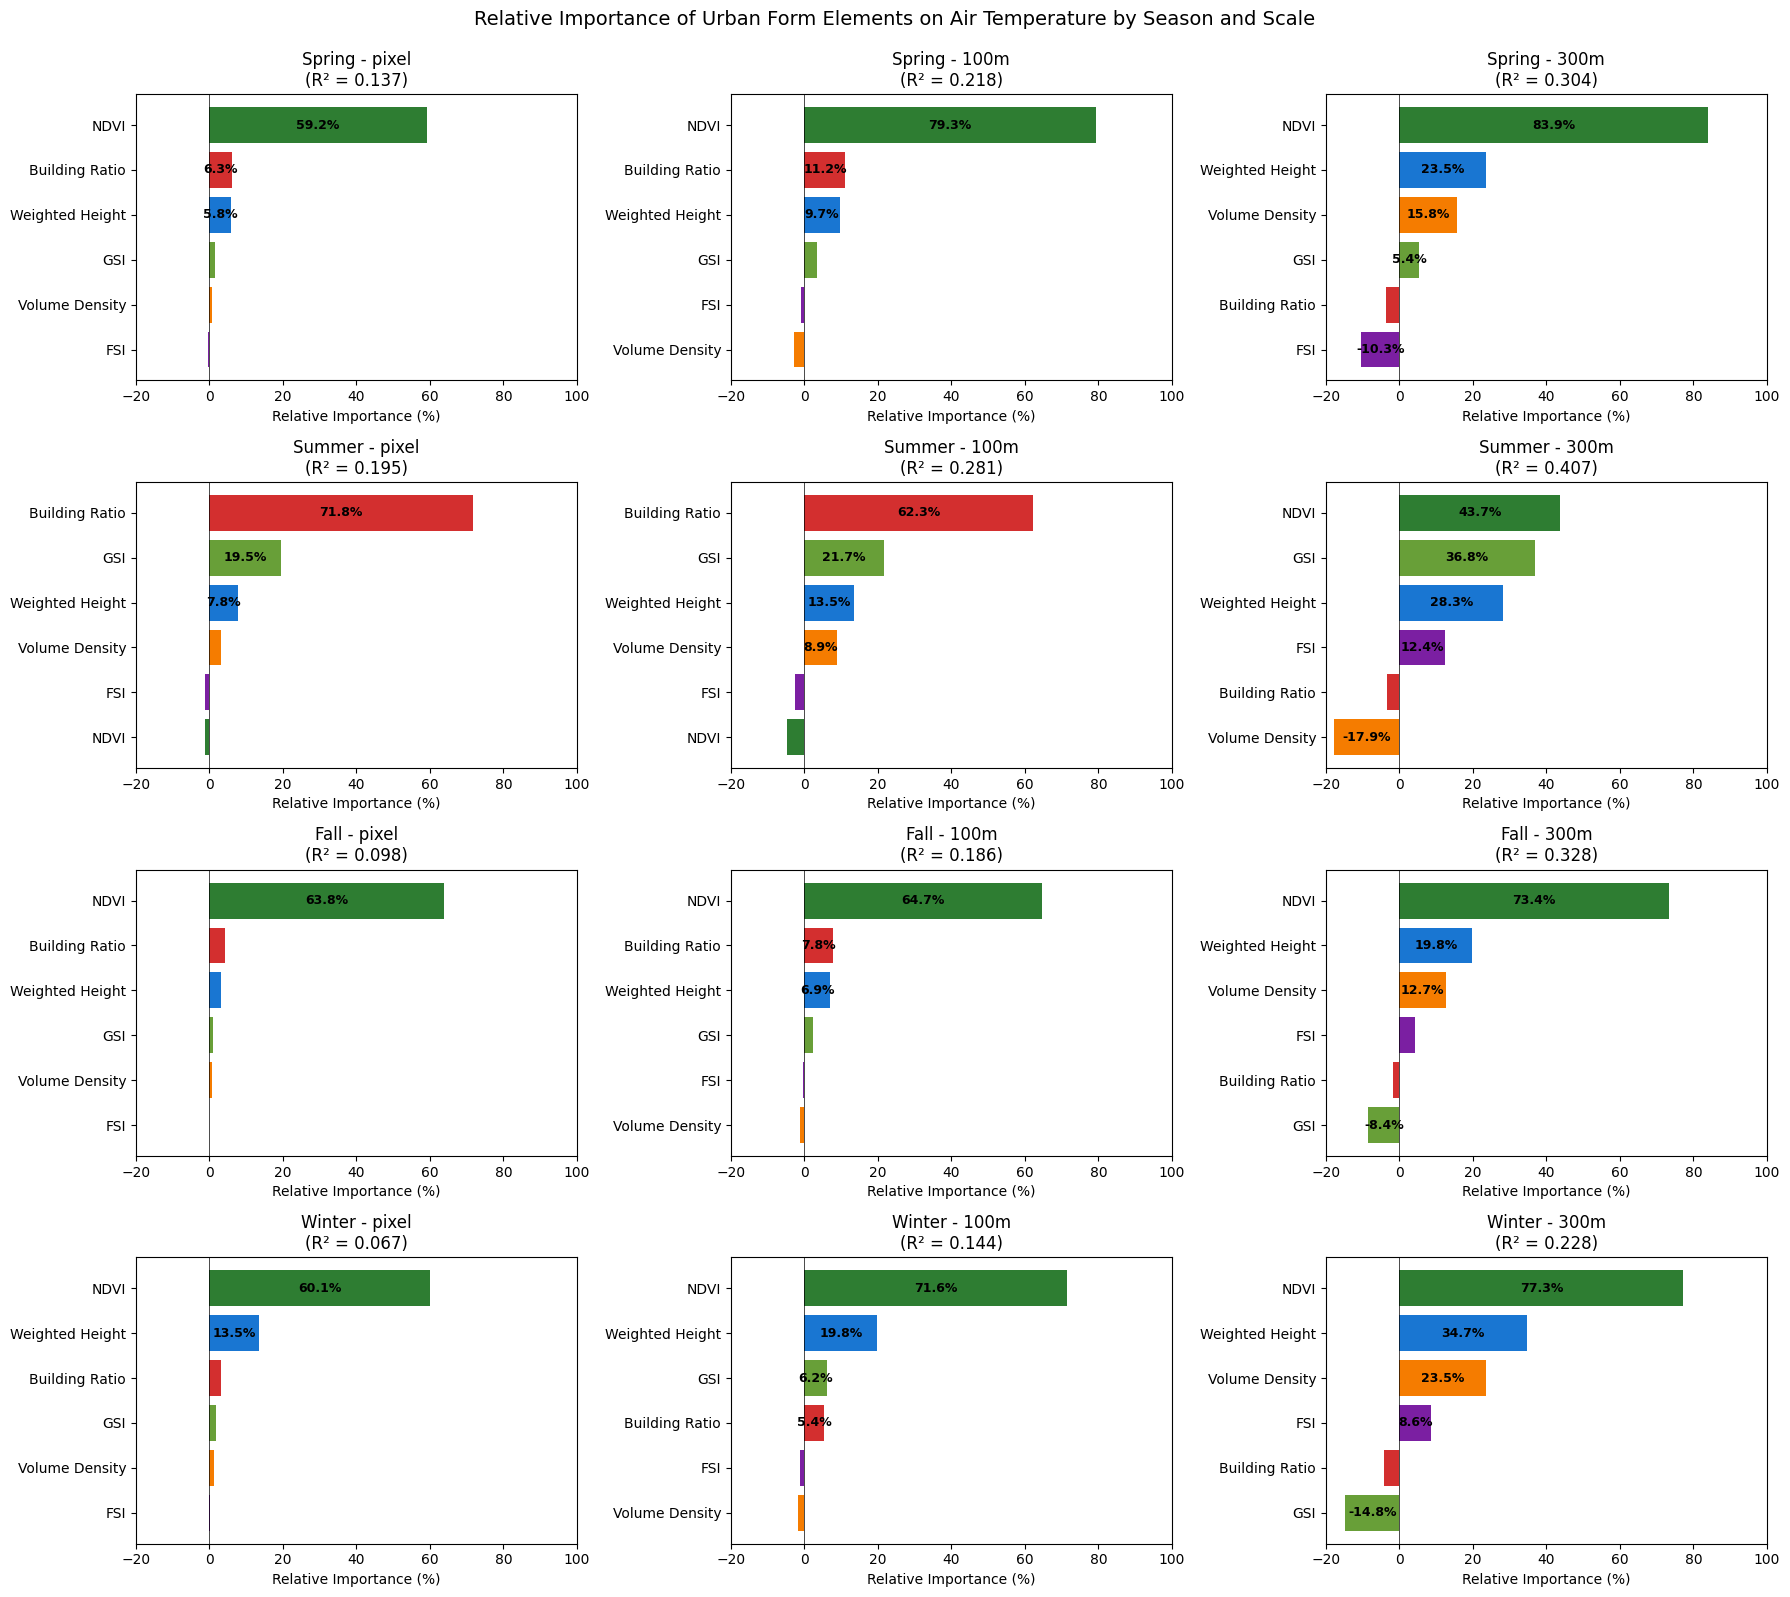

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Genizi results
genizi_results = pd.read_csv(os.path.join(output_folder, 'genizi_results_python.csv'))

# Clean variable names for display
def clean_variable_name(var_name):
    """Remove scale suffixes and clean variable names"""
    cleaned = var_name.replace('_pixel', '').replace('_100m', '').replace('_300m', '')
    name_mapping = {
        'ndvi': 'NDVI',
        'building_ratio': 'Building Ratio',
        'weighted_height': 'Weighted Height',
        'volume_density': 'Volume Density',
        'fsi': 'FSI',
        'gsi': 'GSI'
    }
    return name_mapping.get(cleaned, cleaned)

genizi_results['Variable_Clean'] = genizi_results['Variable'].apply(clean_variable_name)

print("="*80)
print("RELATIVE IMPORTANCE ANALYSIS OF URBAN FORM ELEMENTS ON TEMPERATURE")
print("="*80)

# Print detailed results by season and scale
seasons = ['spring', 'summer', 'fall', 'winter']
scales = ['pixel', '100m', '300m']

for season in seasons:
    print(f"\n{'='*60}")
    print(f"{season.upper()} SEASON ANALYSIS")
    print(f"{'='*60}")
    
    season_data = genizi_results[genizi_results['Season'] == season]
    
    for scale in scales:
        scale_data = season_data[season_data['Scale'] == scale].sort_values('Importance_Pct', ascending=False)
        
        if len(scale_data) > 0:
            r_squared = scale_data['R_squared'].iloc[0]
            print(f"\n{scale.upper()} SCALE (R² = {r_squared:.3f}):")
            print("-" * 40)
            
            # Print each variable's importance
            for _, row in scale_data.iterrows():
                var_name = row['Variable_Clean']
                importance = row['Importance_Pct']
                
                # Create visual bar
                bar_length = int(abs(importance) / 2)  # Scale for display
                if importance >= 0:
                    bar = "+" * bar_length
                    print(f"{var_name:20s}: {importance:6.1f}% |{bar}")
                else:
                    bar = "-" * bar_length
                    print(f"{var_name:20s}: {importance:6.1f}% {bar}|")
            
            # Summary for this scale
            total_positive = scale_data[scale_data['Importance_Pct'] > 0]['Importance_Pct'].sum()
            total_negative = scale_data[scale_data['Importance_Pct'] < 0]['Importance_Pct'].sum()
            print(f"\nTotal positive importance: {total_positive:.1f}%")
            print(f"Total negative importance: {total_negative:.1f}%")

# Create comprehensive visualization
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
fig.suptitle('Relative Importance of Urban Form Elements on Temperature by Season and Scale', 
             fontsize=16, y=0.995)

# Color scheme
colors = {
    'NDVI': '#2E7D32',  # Green
    'Building Ratio': '#D32F2F',  # Red
    'Weighted Height': '#1976D2',  # Blue
    'Volume Density': '#F57C00',  # Orange
    'FSI': '#7B1FA2',  # Purple
    'GSI': '#689F38'  # Light Green
}

for i, season in enumerate(seasons):
    for j, scale in enumerate(scales):
        ax = axes[i, j]
        
        # Get data for this season-scale combination
        data = genizi_results[(genizi_results['Season'] == season) & 
                             (genizi_results['Scale'] == scale)].sort_values('Importance_Pct', ascending=True)
        
        if len(data) > 0:
            # Create horizontal bar chart
            y_pos = np.arange(len(data))
            bars = ax.barh(y_pos, data['Importance_Pct'], 
                          color=[colors.get(name, 'gray') for name in data['Variable_Clean']])
            
            # Customize
            ax.set_yticks(y_pos)
            ax.set_yticklabels(data['Variable_Clean'])
            ax.set_xlabel('Relative Importance (%)')
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            
            # Add title with R²
            r_squared = data['R_squared'].iloc[0]
            ax.set_title(f'{season.capitalize()} - {scale}\n(R² = {r_squared:.3f})')
            
            # Add value labels
            for k, (idx, row) in enumerate(data.iterrows()):
                value = row['Importance_Pct']
                if abs(value) > 5:  # Only label if > 5%
                    ax.text(value/2, k, f'{value:.1f}%', 
                           ha='center', va='center', fontsize=9, fontweight='bold')
            
            # Set x-axis limits
            ax.set_xlim(-30, 100)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'relative_importance_all_seasons.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Most important variables by season
print("\nMOST IMPORTANT VARIABLE BY SEASON AND SCALE:")
print("-" * 60)
for season in seasons:
    print(f"\n{season.upper()}:")
    season_data = genizi_results[genizi_results['Season'] == season]
    
    for scale in scales:
        scale_data = season_data[season_data['Scale'] == scale]
        if len(scale_data) > 0:
            top_var = scale_data.loc[scale_data['Importance_Pct'].idxmax()]
            print(f"  {scale:5s}: {top_var['Variable_Clean']:20s} ({top_var['Importance_Pct']:.1f}%)")

# R² comparison
print("\n\nMODEL PERFORMANCE (R²) BY SEASON AND SCALE:")
print("-" * 60)
r2_summary = genizi_results.groupby(['Season', 'Scale'])['R_squared'].first().unstack()
print(r2_summary.round(3))

# Create a single summary plot
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for grouped bar chart
x = np.arange(len(seasons))
width = 0.25

for i, scale in enumerate(scales):
    scale_importance = []
    for season in seasons:
        # Get NDVI importance for this season-scale
        data = genizi_results[(genizi_results['Season'] == season) & 
                             (genizi_results['Scale'] == scale) & 
                             (genizi_results['Variable_Clean'] == 'NDVI')]
        if len(data) > 0:
            scale_importance.append(data['Importance_Pct'].iloc[0])
        else:
            scale_importance.append(0)
    
    ax.bar(x + i*width, scale_importance, width, label=f'{scale} scale')

ax.set_xlabel('Season')
ax.set_ylabel('NDVI Relative Importance (%)')
ax.set_title('NDVI Importance Across Seasons and Scales')
ax.set_xticks(x + width)
ax.set_xticklabels([s.capitalize() for s in seasons])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'ndvi_importance_comparison.png'), dpi=300)
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE - Ready for discussion!")
print("="*80)